Importing libraries

In [ ]:
import os
import cv2
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns


from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import shuffle

from keras import Sequential, Input, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Dropout

import warnings
warnings.filterwarnings('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def walk_through_dir(filepath):
    for dirpath, dirnames, filenames in os.walk(filepath):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
    print()

def get_filetypes(filepath):
    exts = set(os.path.splitext(f)[1] for dir,dirs,files in os.walk(filepath) for f in files)
    print("File extentions on image directory: ", exts)
    return exts

def process_img(filepath):
    filenames = list(Path(filepath).glob(r'**/*{}'.format('jpg')))
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filenames))

    filepaths = pd.Series(filenames, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df.sample(frac=1)


In [ ]:
canada_train_path = '/content/drive/MyDrive/AI4SD/Canada/train'
canada_test_path = '/content/drive/MyDrive/AI4SD/Canada/test'
canada_val_path = '/content/drive/MyDrive/AI4SD/Canada/valid'
# Process Data
canada_train_df1 = process_img(canada_train_path)
canada_val_df1 = process_img(canada_val_path)
canada_test_df1 = process_img(canada_test_path)

In [ ]:
def show_image_sample(df, num_images=16):
    selected_data = df.head(num_images)
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(selected_data.iloc[i].Filepath))
        ax.set_title(selected_data.iloc[i].Label)
    plt.tight_layout()
    plt.show()

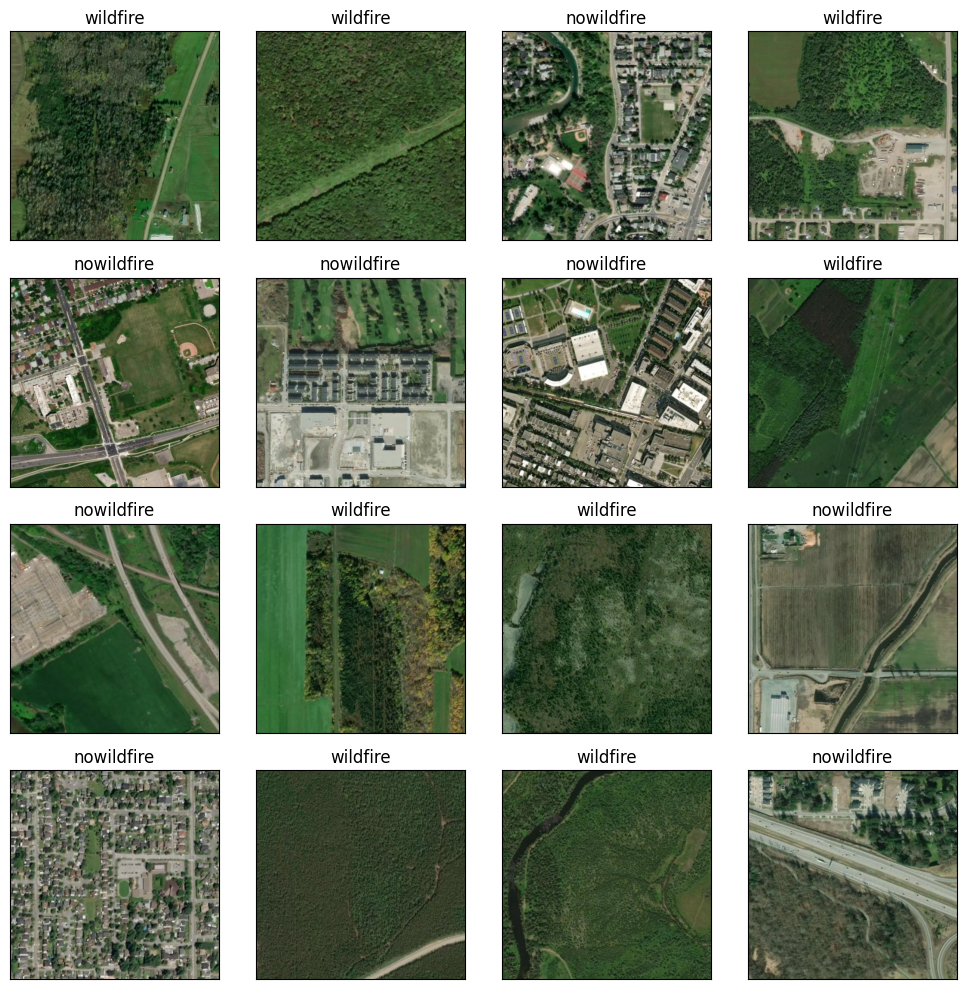

In [ ]:
show_image_sample(canada_train_df1)

In [ ]:
import cv2
import pandas as pd
from tqdm import tqdm
from skimage import exposure

def atmospheric_correction(image):
    # Split the image into its RGB components
    R, G, B = cv2.split(image)

    # Apply histogram equalization to each channel
    equalized_R = exposure.equalize_hist(R)
    equalized_G = exposure.equalize_hist(G)
    equalized_B = exposure.equalize_hist(B)

    # Merge the channels back together
    equalized_image = cv2.merge([equalized_R, equalized_G, equalized_B])
    return equalized_image

def preprocess_dataframe(df):
    processed_images = []
    for filepath in tqdm(df['Filepath'], desc='Processing Images', unit='image'):
        # Read the image in color (BGR format)
        image = cv2.imread(str(filepath), cv2.IMREAD_COLOR)

        # Convert BGR to RGB
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Apply Atmospheric Correction
        corrected_image = atmospheric_correction(image_rgb)

        # Add the corrected image to the list
        processed_images.append(corrected_image)

    processed_df = pd.DataFrame({
        'Processed_Image': processed_images,
        'Label': df['Label']
    })
    return processed_df


In [ ]:
canada_test_df=canada_test_df1.sample(frac=0.07,random_state=1)
canada_train_df=canada_train_df1.sample(frac=0.07,random_state=1)
canada_val_df=canada_val_df1.sample(frac=0.07,random_state=1)

In [ ]:
canada_train_processed_df = preprocess_dataframe(canada_train_df)
canada_val_processed_df = preprocess_dataframe(canada_val_df)
canada_test_processed_df = preprocess_dataframe(canada_test_df)

Processing Images: 100%|██████████| 441/441 [02:24<00:00,  3.06image/s]


In [ ]:
def show_processed_image_sample(df, num_images=16):
    selected_data = df.head(num_images)
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        image = selected_data.iloc[i]['Processed_Image']

        ax.imshow(image)
        ax.set_title("Image "+str(i))
        ax.axis('off')

    plt.tight_layout()
    plt.show()

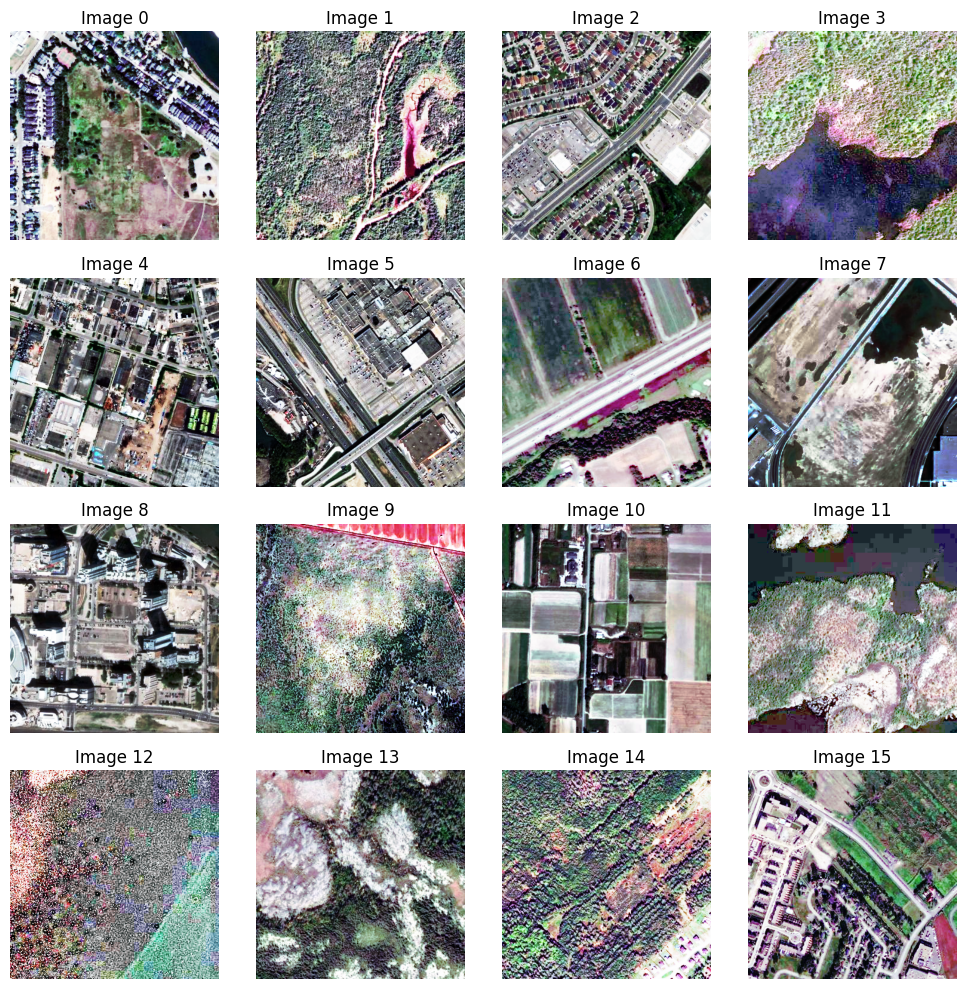

In [ ]:
show_processed_image_sample(canada_train_processed_df)

In [ ]:
cali_test_path = '/content/drive/MyDrive/AI4SD/California/test'
cali_test_df = process_img(cali_test_path)
cali_test_processed_df = preprocess_dataframe(cali_test_df)

Processing Images: 100%|██████████| 429/429 [01:30<00:00,  4.75image/s]


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd

class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image = self.dataframe.iloc[idx]['Processed_Image'].astype(np.float32)
        label = self.dataframe.iloc[idx]['Label']
        label = 1 if label == 'wildfire' else 0

        if self.transform:
            image = self.transform(image)

        return image, label

val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

train_dataset = ImageDataset(canada_train_processed_df, transform=val_transform)
val_dataset = ImageDataset(canada_val_processed_df, transform=val_transform)
train_loader = DataLoader(train_dataset, batch_size= , shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


alexnet = models.alexnet(pretrained=True)
alexnet.classifier[6] = nn.Linear(4096, 2)

# Loss and optimizer with L2 regularization
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(alexnet.parameters(), lr=0.00001, weight_decay=1e-5)

# Early Stopping parameters
best_val_loss = float('inf')
patience = 5
patience_counter = 0

# Training and Validation
num_epochs = 50
for epoch in range(num_epochs):
    # Training Loop
    alexnet.train()
    train_correct = 0
    train_total = 0
    for images, labels in train_loader:
        outputs = alexnet(images)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_accuracy = 100 * train_correct / train_total

    alexnet.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = alexnet(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * val_correct / val_total
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(alexnet.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

alexnet.load_state_dict(torch.load('best_model.pth'))

torch.save(alexnet, 'alexnet_full_model.pth')

torch.save(alexnet.state_dict(), 'alexnet_state_dict.pth')

Epoch [1/50], Loss: 0.7692, Val Loss: 0.7937
Epoch [2/50], Loss: 0.7405, Val Loss: 0.7732
Epoch [3/50], Loss: 0.7149, Val Loss: 0.7549
Epoch [4/50], Loss: 0.6908, Val Loss: 0.7378
Epoch [5/50], Loss: 0.6695, Val Loss: 0.7225
Epoch [6/50], Loss: 0.6497, Val Loss: 0.7083
Epoch [7/50], Loss: 0.6311, Val Loss: 0.6949
Epoch [8/50], Loss: 0.6136, Val Loss: 0.6823
Epoch [9/50], Loss: 0.5975, Val Loss: 0.6705
Epoch [10/50], Loss: 0.5823, Val Loss: 0.6595
Epoch [11/50], Loss: 0.5682, Val Loss: 0.6490
Epoch [12/50], Loss: 0.5548, Val Loss: 0.6392
Epoch [13/50], Loss: 0.5420, Val Loss: 0.6297
Epoch [14/50], Loss: 0.5298, Val Loss: 0.6207
Epoch [15/50], Loss: 0.5182, Val Loss: 0.6121
Epoch [16/50], Loss: 0.5068, Val Loss: 0.6037
Epoch [17/50], Loss: 0.4963, Val Loss: 0.5958
Epoch [18/50], Loss: 0.4861, Val Loss: 0.5882
Epoch [19/50], Loss: 0.4764, Val Loss: 0.5810
Epoch [20/50], Loss: 0.4671, Val Loss: 0.5742
Epoch [21/50], Loss: 0.4582, Val Loss: 0.5677
Epoch [22/50], Loss: 0.4497, Val Loss: 0.56

In [ ]:
val_loss=[0.7937, 0.7732, 0.7549, 0.7378, 0.7225, 0.7083, 0.6949, 0.6823, 0.6705, 0.6595,
 0.6490, 0.6392, 0.6297, 0.6207, 0.6121, 0.6037, 0.5958, 0.5882, 0.5810, 0.5742,
 0.5677, 0.5614, 0.5554, 0.5498, 0.5443, 0.5392, 0.5342, 0.5294, 0.5250, 0.5208,
 0.5167, 0.5131, 0.5093, 0.5059, 0.5025, 0.4995, 0.4968, 0.4938, 0.4910, 0.4884,
 0.4860, 0.4835, 0.4813, 0.4791, 0.4768, 0.4750, 0.4731, 0.4714, 0.4700, 0.4684]
loss=[0.7692, 0.7405, 0.7149, 0.6908, 0.6695, 0.6497, 0.6311, 0.6136, 0.5975, 0.5823,
 0.5682, 0.5548, 0.5420, 0.5298, 0.5182, 0.5068, 0.4963, 0.4861, 0.4764, 0.4671,
 0.4582, 0.4497, 0.4415, 0.4338, 0.4263, 0.4191, 0.4122, 0.4055, 0.3992, 0.3931,
 0.3873, 0.3817, 0.3764, 0.3711, 0.3660, 0.3613, 0.3568, 0.3524, 0.3482, 0.3442,
 0.3403, 0.3365, 0.3329, 0.3295, 0.3261, 0.3229, 0.3198, 0.3169, 0.3141, 0.3112]


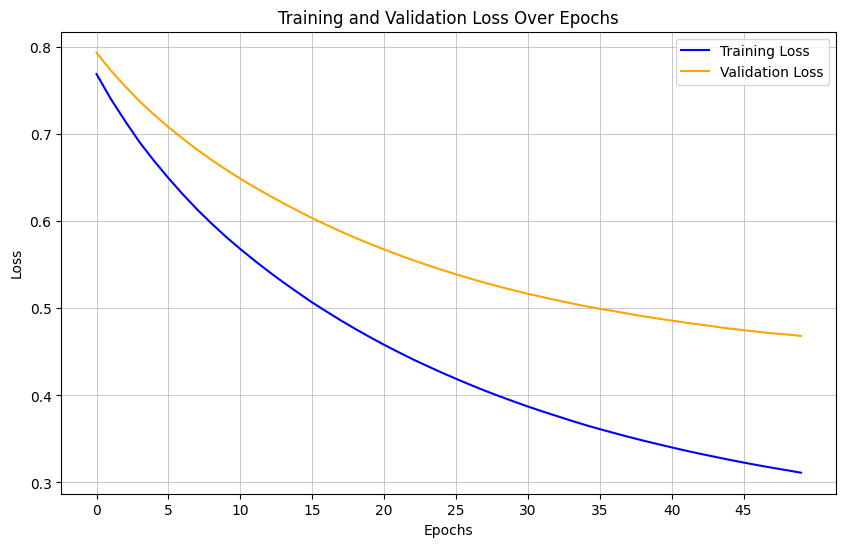

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(linestyle='-', linewidth=0.5)
plt.xticks(range(0, 50, 5))
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import DataLoader

def evaluate_model(model, dataloader):
    model.eval()

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels)
            all_preds.extend(predicted)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    f1 = f1_score(all_labels, all_preds, average='binary')

    return accuracy, precision, recall, f1

alexnet.load_state_dict(torch.load('best_model.pth'))

accuracy, precision, recall, f1 = evaluate_model(alexnet, val_loader)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.8987
Precision: 0.8750
Recall: 0.9545
F1-Score: 0.9130


In [ ]:
# Test on CANADA
test_dataset = ImageDataset(canada_test_processed_df, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluate on Test set
accuracy, precision, recall, f1 = evaluate_model(alexnet, test_loader)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.9557
Precision: 0.9348
Recall: 0.9885
F1-Score: 0.9609


In [ ]:
# Evaluate on cali Test set
test_dataset = ImageDataset(cali_test_processed_df, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
accuracy, precision, recall, f1 = evaluate_model(alexnet, test_loader)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.8159
Precision: 0.9193
Recall: 0.6916
F1-Score: 0.7893
